In [1]:
import copy
import numpy as np
import pandas
import os
import json
import itertools

import csv
import pandas as pd

import matplotlib.pyplot as plt
from parameters import *


def split_length(total_length, max_length):
    '''
    Split a float / int into a list with max_length
    '''
    print('total_length = ' + str(total_length) + ' max_length = ' + str(max_length))
    if total_length <= max_length:
        output = [total_length]
    else:
        floor = int(total_length // max_length)
        remaining = (total_length - floor * max_length)
        output = [max_length] * floor
        if remaining != 0:
            output += [remaining]
    print('output = ' + str(output))
    return(output)


def split_list(input_list, max_length):
    '''
    Split a list into a list of lists with max_length
    '''
    length_list = split_length(len(input_list), max_length)
    output = []
    start_id = 0
    for le in length_list:
        output += [input_list[start_id: start_id + le]]
        start_id += le
    print('splitlist first value len = ' + str(len(output[0])))
    return(output)


import concurrent.futures as cf
import multiprocessing

try:
    from tqdm import tqdm
    imported_tqdm = True
except (ImportError, ModuleNotFoundError):
    imported_tqdm = False


def parallel_run(func,
                 run_list,
                 n_workers,
                 func_args=(),
                 func_kwargs={},
                 input_as_kwargs=False,
                 processor_no_limited=False,
                 use_tqdm=False,
                 thread_pool=False):
    '''
    Parameters
    ----------
    func                    : function
    run_list                : list
    n_workers               : int
    func_args               : tuple, optional
    func_kwargs             : dict, optional
    input_as_kwargs         : {True, False (default)}, optional
    processor_no_limited    : {True, False (default)}, optional
    use_tqdm                : {True, False (default)}, optional
    thread_pool             : {True, False (default)}, optional
    '''
    run_list_t = run_list

    if processor_no_limited:
        n_workers_use = min(multiprocessing.cpu_count(), n_workers)
    else:
        n_workers_use = n_workers
    n_workers_use = min(n_workers, len(run_list_t))

    u_tqdm = False
    if use_tqdm:
        if imported_tqdm:
            u_tqdm = True
        else:
            warnings.warn('\'tqdm\' not installed.')

    retry_id_list = []
    if n_workers_use == 1:
        if u_tqdm:
            if input_as_kwargs:
                result = [func(*func_args, **x, **func_kwargs)
                          for x in tqdm(run_list_t)]
            else:
                result = [func(x, *func_args, **func_kwargs)
                          for x in tqdm(run_list_t)]
        else:
            if input_as_kwargs:
                result = [func(*func_args, **x, **func_kwargs)
                          for x in run_list_t]
            else:
                result = [func(x, *func_args, **func_kwargs)
                          for x in run_list_t]
    else:
        if not thread_pool:
            ex = cf.ProcessPoolExecutor(max_workers=n_workers_use)
        else:
            ex = cf.ThreadPoolExecutor(max_workers=n_workers_use)

        if input_as_kwargs:
            job_list = [ex.submit(func, *func_args, **x, **func_kwargs)
                        for x in run_list_t]
        else:
            job_list = [ex.submit(func, x, *func_args, **func_kwargs)
                        for x in run_list_t]

        if u_tqdm:
            tqdm_kwargs = {
                'total': len(job_list),
                'unit_scale': True
            }
            for f in tqdm(cf.as_completed(job_list), **tqdm_kwargs):
                pass
        ex.shutdown(wait=True)

        result = [0] * len(job_list)
        for j, job in enumerate(job_list):
            try:
                result[j] = job.result()
            except Exception as e:
                msg = 'item ' + str(j) + ' with error: ' + str(e)
                raise RuntimeError(msg)
    return(result)


title_fontsize=24
label_fontsize=22
legend_fontsize=20
tick_fontsize = 22

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
def get_ygate_fidelity(
    x, y, 
    config_template=CONFIG_TEMPLATE_JSON, 
    pulse_data_path='/tmp/ygate.csv',
    output_objf_path='/tmp/ygate_fidelity.csv',
    cleanup=True, 
    verbose=False):
    
    BASE_DIR = '../../'
      
    with open(pulse_data_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1).values)
    
    if verbose:
        !cd $BASE_DIR && julia check_RY_pulse_objective_function.jl \
            --config_path $config_template \
            --pulse_data_path $pulse_data_path \
            --output_objf_path $output_objf_path
    else:
        !cd $BASE_DIR && julia check_RY_pulse_objective_function.jl \
            --config_path $config_template \
            --pulse_data_path $pulse_data_path \
            --output_objf_path $output_objf_path > /dev/null

    fidelity_data =  1 - pd.read_csv(output_objf_path, header=None).abs()
    
    if cleanup:
        !rm -f $pulse_data_path
        !rm -f $output_objf_path
    
    return fidelity_data

In [3]:
def get_fidelity(csv_path, n_workers=1, max_length = 10000, tmp_dir = '/tmp'):
    n_para = 20
    pulse_d = pandas.read_csv(csv_path)#, header=None)
    y_values = pulse_d.iloc[:, 1:n_para+1].to_numpy()
    x_values = pulse_d.iloc[:, n_para+1:].to_numpy()
    
    x_values_split = split_list(x_values, max_length)
    y_values_split = split_list(y_values, max_length)
    run_list = []
    for j, val_in in enumerate(zip(x_values_split, y_values_split)):
        x, y = val_in
        run_list.append(dict(
            x=x,
            y=y,
            pulse_data_path=os.path.join(tmp_dir, 'ygate_{j}.csv'.format(j=j)),
            output_objf_path=os.path.join(tmp_dir, 'ygate_fidelity_{j}.csv'.format(j=j)))
        )
    #print(run_list)
    fidelities_raw_list = parallel_run(
        func=get_ygate_fidelity,
        run_list=run_list,
        n_workers=n_workers,
        input_as_kwargs=True,
        use_tqdm=True)
    fidelities_list = [fr.to_numpy().transpose()[0] for fr in fidelities_raw_list]
    fidelities = np.hstack(fidelities_list)

    angles = x_values
    return angles, fidelities

In [4]:
csv_paths = [
    'keras_results.csv',
    #'/local/ml4qcontrol/data_pulse/yrotation/D1_10_Pmin_200/ry_test_configfile_config_template_D1_10_Pmin_200.json_randomseed_0001.csv',
]

angles_list = []
fidelities_list = []

for csv_path in csv_paths:
    angles, fidelities = get_fidelity(csv_path, n_workers=32, max_length=40000, tmp_dir = '/tmp')
    angles_list.append(angles)
    fidelities_list.append(fidelities)

total_length = 16384 max_length = 40000
output = [16384]
splitlist first value len = 16384
total_length = 16384 max_length = 40000
output = [16384]
splitlist first value len = 16384


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.10s/it]


In [5]:
title_fontsize=24
label_fontsize=22
legend_fontsize=20
tick_fontsize = 22

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [6]:
data_id = 0

In [7]:
np.mean(fidelities_list[data_id])

0.9782722279185097

In [8]:
low_fid_count = 0
idx = 0
new_fidelities_list = []
new_angles_list = []
bad_fidelities_list = []
bad_angles_list = []
for (x,y), fidelity in np.ndenumerate(fidelities_list):
    if (fidelity < 0.99):
        bad_fidelities_list.append(fidelity)
        bad_angles_list.append(angles_list[0][idx])
        #print('angle = ' + str(angles_list[0][idx]) + ' fidelity = ' + str(fidelity))
        low_fid_count += 1
    if (angles_list[0][idx] < 3.1):
        new_fidelities_list.append(fidelity)
        new_angles_list.append(angles_list[0][idx])
        #print('angle = ' + str(angles_list[0][idx]))
    idx += 1
new_angles_list = np.array(new_angles_list)

In [9]:
def flatten(l):
    return [item for sublist in l for item in sublist]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
1864
16384
16384


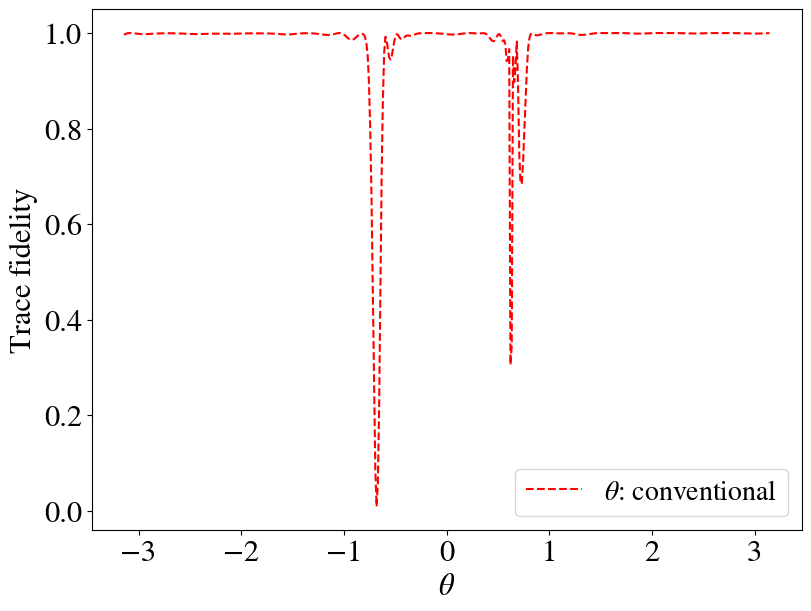

In [10]:
n_resolution = 512

fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)

axs = ax
print(type(fidelities_list[0]))
print(type(angles_list[0]))
print(len(bad_fidelities_list))

which_data = 0
line_style_list = ['--r']
label_list = [r'$\theta$: conventional']
for which_angle, ls, lb in zip(range(1), line_style_list, label_list):
#while 0:
    angles = angles_list[which_data]
    fidelities = fidelities_list[which_data]
    #angles = new_angles_list
    #fidelities = new_fidelities_list
    #print(angles.shape)
    print(len(fidelities))
    print(len(angles))
    angle_ids = np.array(np.rint((angles + np.pi) / (2. * np.pi) * (n_resolution - 1)), dtype=int)

    f_aver_list = np.zeros(n_resolution)
    counter_list = np.zeros(n_resolution)
    for angle_id, f in list(zip(angle_ids, fidelities)):
        f_aver_list[angle_id[which_angle]] += f
        counter_list[angle_id[which_angle]] += 1
    f_aver_list = f_aver_list / counter_list

    axs.plot(np.linspace(-np.pi, np.pi, n_resolution), f_aver_list, ls, label=lb)

#print(len(bad_fidelities_list))
#print(len(flatten(bad_angles_list)))


axs.set_xlabel(r'$\theta$', fontsize=label_fontsize)
axs.set_ylabel(r'Trace fidelity', fontsize=label_fontsize)
axs.tick_params(axis='both', which='major', labelsize=label_fontsize)
# axs.set_ylim([0.92, 1.005])
axs.legend(fontsize=legend_fontsize, ncol=1, loc='best')
plt.show()

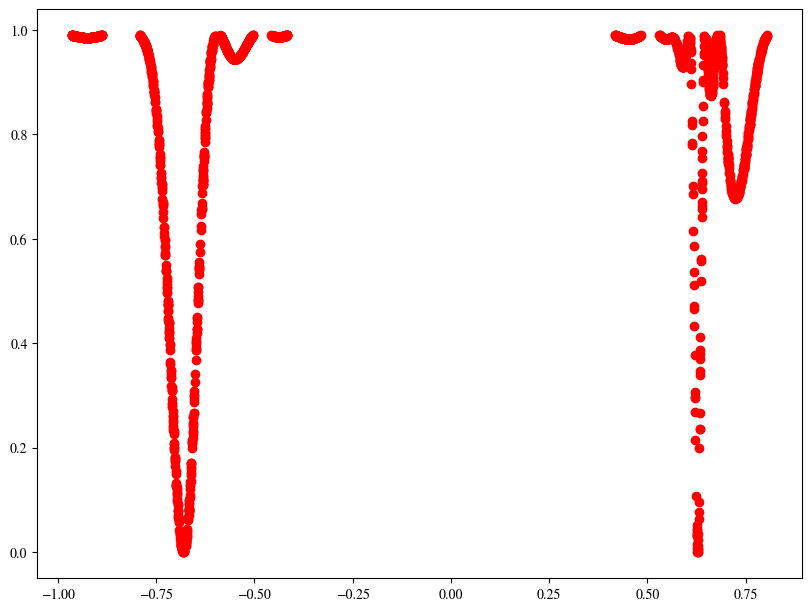

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)
ax.scatter(flatten(bad_angles_list), bad_fidelities_list, c='r', label=label_list[0])
axs.set_xlabel(r'$\theta$', fontsize=label_fontsize)
axs.set_ylabel(r'Trace fidelity', fontsize=label_fontsize)
axs.tick_params(axis='both', which='major', labelsize=label_fontsize)
axs.legend(fontsize=legend_fontsize, ncol=1, loc='best')
plt.show()